In [1]:
# import Registration
# from utils.utils import *
import rasterio
from fastai.vision import *
import torchvision.transforms

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
model=models.vgg16_bn(pretrained=True)
model.cuda()
model.eval()
normalize1=torchvision.transforms.Normalize(imagenet_stats[0], imagenet_stats[1])

/home/staff/xin/miniconda3/envs/fastaiV1/lib/python3.6/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 Quadro 2000 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [4]:
import cv2

In [64]:
time1=rasterio.open('/home/staff/xin/Downloads/registration/shanghe2-1-20181011_1.tif')
time2=rasterio.open('/home/staff/xin/Downloads/registration/shanghe-2-1-20190228_1.tif')

In [65]:
IY=time2.read()
IX=time1.read()

In [66]:
IX=IX.transpose(1,2,0)
IY=IY.transpose(1,2,0)

In [67]:
from skimage.transform import rescale
IY=rescale(IY,scale=0.25,order=0,preserve_range=True)
IX=rescale(IX,scale=0.25,order=0,preserve_range=True)

/home/staff/xin/miniconda3/envs/fastaiV1/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/staff/xin/miniconda3/envs/fastaiV1/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/staff/xin/miniconda3/envs/fastaiV1/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [70]:
IY=IY.astype('uint8')
IX=IX.astype('uint8')

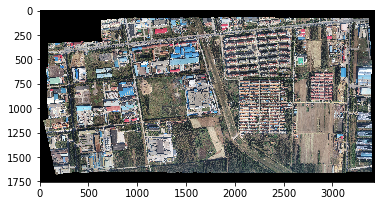

In [71]:
plt.imshow(IX)

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
def processdata(data1):
    test1=cv2.resize(data1,(224,224))
    test1 = pil2tensor(test1,np.float32)
    test1=test1.div_(255)
    test1=normalize1(test1)
    test1 = test1.cuda()
    test1=test1.unsqueeze(0)
    return test1

In [74]:
data1=processdata(IX)
data2=processdata(IY)

In [75]:

# this is a hook (learned about it here: https://forums.fast.ai/t/how-to-find-similar-images-based-on-final-embedding-layer/16903/13)
# hooks are used for saving intermediate computations
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()
        


In [76]:
D1 = SaveFeatures(model._modules.get('features')._modules.get('23'))
D2 = SaveFeatures(model._modules.get('features')._modules.get('33'))
D3 = SaveFeatures(model._modules.get('features')._modules.get('43'))

In [77]:
predict=torch.cat((data1,data2),dim=0)

In [78]:
 with torch.no_grad():
        _ = model(predict)

In [79]:
D1.features.shape

(2, 256, 28, 28)

In [80]:
D2.features.shape

(2, 512, 14, 14)

In [81]:
DX1, DY1 = np.reshape(D1.features[0], [256,-1]).transpose(1,0), np.reshape(D1.features[1], [256,-1]).transpose(1,0)
DX2, DY2 = np.reshape(D2.features[0], [512,-1]).transpose(1,0), np.reshape(D2.features[1], [512,-1]).transpose(1,0)
DX3, DY3 = np.reshape(D3.features[0], [512,-1]).transpose(1,0), np.reshape(D3.features[1], [512,-1]).transpose(1,0)

In [82]:
DX1, DY1 = DX1 / np.std(DX1), DY1 / np.std(DY1)
DX2, DY2 = DX2 / np.std(DX2), DY2 / np.std(DY2)
DX3, DY3 = DX3 / np.std(DX3), DY3 / np.std(DY3)

In [83]:
from utils.utils import pairwise_distance,pd_expand,match,gaussian_radial_basis,init_sigma2,compute
from lap import lapjv

In [84]:
PD1 = pairwise_distance(DX1, DY1)
PD2 = pd_expand(pairwise_distance(DX2, DY2), 2)
PD3 = pd_expand(pairwise_distance(DX3, DY3), 4)
PD = 1.414 * PD1 + PD2 + PD3


In [85]:
from utils.shape_context import ShapeContext

In [86]:
max_itr = 200
tolerance = 1e-2
freq = 5 # k in the paper
epsilon = 0.5
omega = 0.5
beta = 2.0
lambd = 0.5

SC=ShapeContext()

In [87]:
seq = np.array([[i, j] for i in range(28) for j in range(28)], dtype='int32')

X = np.array(seq, dtype='float32') * 8.0 + 4.0
Y = np.array(seq, dtype='float32') * 8.0 + 4.0

# normalize
X = (X - 112.0) / 224.0
Y = (Y - 112.0) / 224.0

# prematch and select points
C_all, quality = match(PD)
tau_max = np.max(quality)
while np.where(quality >= tau_max)[0].shape[0] <= 128: tau_max -= 0.01

C = C_all[np.where(quality >= tau_max)]
cnt = C.shape[0]

# select prematched feature points
X, Y = X[C[:, 1]], Y[C[:, 0]]
PD = PD[np.repeat(np.reshape(C[:, 1], [cnt, 1]), cnt, axis=1),
        np.repeat(np.reshape(C[:, 0], [1, cnt]), cnt, axis=0)]

N = X.shape[0]
M = X.shape[0]
assert M == N

# precalculation of feature match
C_all, quality = match(PD)

# compute \hat{\theta} and \delta
tau_min = np.min(quality)
tau_max = np.max(quality)
while np.where(quality >= tau_max)[0].shape[0] <= 0.5 * cnt: tau_max -= 0.01
tau = tau_max
delta = (tau_max - tau_min) / 10.0

SCX = SC.compute(X)

# initialization
Z = Y.copy()
GRB = gaussian_radial_basis(Y, beta)
A = np.zeros([M, 2])
sigma2 = init_sigma2(X, Y)

Pr = None

Q = 0
dQ = float('Inf')
itr = 1

# registration process
while itr < 200 and abs(dQ) > tolerance and sigma2 > 1e-4:
    Z_old = Z.copy()
    Q_old = Q

    # for every k iterations
    if (itr - 1) % freq == 0:
        # compute C^{conv}_{\theta}
        C = C_all[np.where(quality >= tau)]
        Lt = PD[C[:, 0], C[:, 1]]
        maxLt = np.max(Lt)
        if maxLt > 0: Lt = Lt / maxLt
        L = np.ones([M, N])
        L[C[:, 0], C[:, 1]] = Lt

        # compute C^{geo}_{\theta}
        SCZ = SC.compute(Z)
        SC_cost = SC.cost(SCZ, SCX)

        # compute C
        L = L * SC_cost

        # linear assignment
        C = lapjv(L)[1]

        # prior probability matrix
        Pr = np.ones_like(PD) * (1.0 - epsilon) / N
        Pr[np.arange(C.shape[0]), C] = 1.0
        Pr = Pr / np.sum(Pr, axis=0)

        tau = tau - delta
        if tau < tau_min: tau = tau_min

    # compute minimization
    Po, P1, Np, tmp, Q = compute(X, Y, Z_old, Pr, sigma2, omega)
    Q = Q + lambd / 2 * np.trace(np.dot(np.dot(A.transpose(), GRB), A))

    # update variables
    dP = np.diag(P1)
    t1 = np.dot(dP, GRB) + lambd * sigma2 * np.eye(M)
    t2 = np.dot(Po, X) - np.dot(dP, Y)
    A = np.dot(np.linalg.inv(t1), t2)
    sigma2 = tmp / (2.0 * Np)
    omega = 1 - (Np / N)
    if omega > 0.99: omega = 0.99
    if omega < 0.01: omega = 0.01
    Z = Y + np.dot(GRB, A)
    lambd = lambd * 0.95
    if lambd < 0.1: lambd = 0.1

    dQ = Q - Q_old
    itr = itr + 1

print('finish: itr %d, Q %d, tau %d' % (itr, Q, tau))
# return ((X*224.0)+112.0)*Xscale, ((Y*224.0)+112.0)*Yscale, ((Z*224.0)+112.0)*Xscale

finish: itr 51, Q -630, tau 1


In [88]:
IX.shape

(1755, 3430, 3)

In [89]:
Xscale = 1.0 * np.array(IX.shape[:2]) / 224.0
Yscale = 1.0 * np.array(IY.shape[:2]) / 224.0

In [90]:
X, Y, Z = ((X*224.0)+112.0)*Xscale, ((Y*224.0)+112.0)*Yscale, ((Z*224.0)+112.0)*Xscale

In [91]:
import numpy as np
from math import exp, log
from scipy.interpolate import Rbf

In [92]:
def tps_warp(Y, T, Y_image, out_shape):
    Y_height, Y_width = Y_image.shape[:2]
    T_height, T_width = out_shape[:2]
#     print(T[:, 0].shape, T[:, 1].shape, Y[:, 0].shape)
    i_func = Rbf(T[:, 0], T[:, 1], Y[:, 0], function='thin-plate')
    j_func = Rbf(T[:, 0], T[:, 1], Y[:, 1], function='thin-plate')

    iT, jT = np.mgrid[:T_height, :T_width]
    iT = iT.flatten()
    jT = jT.flatten()
    print(iT.shape,jT.shape)
    iY = np.int_(i_func(iT, jT))
    jY = np.int_(j_func(iT, jT))

    keep = np.logical_and(iY>=0, jY>=0)
    keep = np.logical_and(keep, iY<Y_height)
    keep = np.logical_and(keep, jY<Y_width)
    iY, jY, iT, jT = iY[keep], jY[keep], iT[keep], jT[keep]

    out_image = np.zeros(out_shape, dtype='uint8')
    out_image[iT, jT, :] = Y_image[iY, jY, :]

    return out_image

In [93]:
registered=tps_warp(Y, Z, IY, IX.shape)

(6019650,) (6019650,)


In [94]:
registered.shape

(1755, 3430, 3)

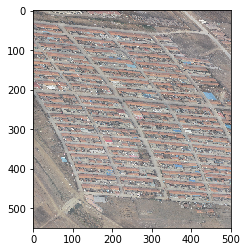

In [100]:
plt.imshow(registered[750:1300,2000:2500])

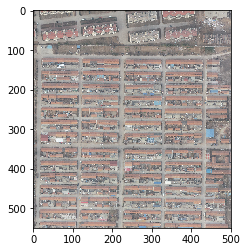

In [102]:
plt.imshow(IY[750:1300,2000:2500])

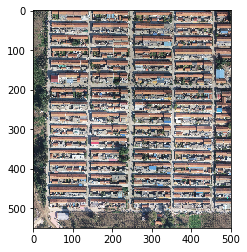

In [101]:
plt.imshow(IX[750:1300,2000:2500])